# WIP: Compile hemorrhage characteristics from Hssayeni dataset
### Creates and saves volume (mL) and attenuation (HU) distributions from Hssayeeni dataset.
### Modified from `get_BHSD_distributions.ipynb`

Hssayeni dataset cannot be downloaded via URL, please sign data use agreement:
https://physionet.org/content/ct-ich/1.3.1/

Download our further segmented hemorrhage masks: [TODO: LINK]

In [1]:
# Directory checks and HF downloads
import os
import tarfile
from huggingface_hub import hf_hub_download

if os.path.isdir('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'):
    file_location = hf_hub_download(repo_id='jmweaver-FDA/insilicoich-pub1', filename='Hssayeni_subtype_masks.tar', repo_type='dataset')
    tar = tarfile.open(file_location, 'r')
    tar.extractall('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1')
else:
    print('Cannot locate Hssayeni dataset in correct directory')
    print('Please download and/or move to correct location.')
    print('Link: https://physionet.org/content/ct-ich/1.3.1/')
    print('Move to insilicoich-pub1/datasets')

### Create and save Pandas dataframe with BHSD hemorrhage characteristics:

In [ ]:
from pathlib import *
import nibabel as nib
import numpy as np
import pandas as pd
import sys
import skimage as sk

regenerate_spreadsheet = True
save_distributions = True
verbose = False # set to False to disable pesky things like printing file IDs and cluster numbers used for debugging

Hssayeni_path = Path('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1') # TODO: move to public location if necessary

if not regenerate_spreadsheet:
    try:
        df = pd.read_csv('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/Hssayeni_hemorrhage_characteristics.csv')
        print('Found Hssayeni spreadsheet')
    except:
        print('CSV not found, regenerating spreadsheet...')
        regenerate_spreadsheet = True

if regenerate_spreadsheet:
    # initialize empty dataframe
    df = pd.DataFrame(columns=['Dataset', 'Data_ID', 'Type', 'Volume_[mL]', 'Mean_HU', 'Median_HU', 'dx', 'dy', 'dz', 'num_slices', 'z_dist'])

    cluster_threshold = 15 # clusters an area less than this number (in voxels) are excluded, necessary because manual and automatic segmentation leave some spurious clusters of voxels

    labels = ["bkg", "EDH", "IPH", "IVH", "SAH", "SDH"] # 0, 1, 2, 3, 4, 5; labels used by BHSD dataset creators

    img_dir = Hssayeni_path / "ct_scans"
    truth_dir = Hssayeni_path / "subtype_masks"

    row_idx = 0

    # label_names = sorted(os.listdir(img_dir))
    label_names = sorted(os.listdir(truth_dir))
    label_names.remove('ICH.ctbl')

    for idx, file in enumerate(label_names):
        file = file.split('_')[0] + '.nii'
        print(str(file))
        img = nib.load(img_dir / file)
        [dx, dy, dz] = img.header['pixdim'][1:4]
        image = img.get_fdata()

        file = file.split('.')[0] + '_1.nii'
        mask = nib.load(truth_dir / file).get_fdata()

        for label_idx in range(1, len(labels)): # skip background

            hemorrhage_volume = (len(np.argwhere(mask == label_idx)))*((dx*dy*dz)/1000)

            if hemorrhage_volume != 0:
                hemorrhage_mask = np.where(mask == label_idx, 1, 0) # create new hemorrhage mask for corresponding lesion type

                label_mask, num = sk.measure.label(hemorrhage_mask, return_num=True, connectivity=1)
                if verbose: print('number of ' + str(labels[label_idx]) + ' clusters: ' + str(num))

                for cluster_idx in range(1,num+1):
                    cluster = np.where(label_mask == cluster_idx, 1, 0)
                    if verbose: print('cluster idx: '+str(cluster_idx)+', count: '+str(np.count_nonzero(cluster)))
                    if np.count_nonzero(cluster) > cluster_threshold:
                        num_slices = 0
                        for slice_idx in range(cluster.shape[2]):
                            slice = cluster[:, :, slice_idx]
                            if np.any(slice): # check if hemorrhage
                                num_slices += 1

                        hemorrhage_volume = (len(np.argwhere(cluster == 1)))*((dx*dy*dz)/1000)

                        z_dist = num_slices * dz

                        # calculate mean and median HU
                        lesion_only = np.multiply(image, cluster)
                        lesion_only[lesion_only < -500] = 0
                        mean_HU = np.mean(lesion_only[np.nonzero(cluster)])
                        median_HU = np.median(lesion_only[np.nonzero(cluster)])

                        # add to data frame and move on
                        df.loc[row_idx] = ['Hssayeni', str(file), labels[label_idx], hemorrhage_volume, mean_HU, median_HU, dx, dy, dz, num_slices, z_dist]
                        row_idx += 1

    df.to_csv('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/Hssayeni_unique_hemorrhage_characteristics.csv')
    

049.nii
050.nii
051.nii
052.nii
053.nii
058.nii
066.nii
067.nii
068.nii
069.nii
070.nii
071.nii
072.nii
073.nii
074.nii
075.nii
076.nii
077.nii
078.nii
079.nii
080.nii
081.nii
082.nii
083.nii
084.nii
085.nii
086.nii
087.nii
088.nii
089.nii
090.nii
091.nii
092.nii
093.nii
094.nii
097.nii


### Plot Hssayeni distributions (MANUSCRIPT FIGURE?)
Note: Mean +- standard deviation labels were manually added to the plots.

Mean values of each metric by hemorrhage type:
        Mean_HU  Volume_[mL]  num_slices     z_dist
Type                                               
EDH   59.678912    12.286126    7.142857  35.714287
IPH   46.903984     3.770661    2.857143  14.285714
IVH   39.081255     1.950966    3.625000  18.125000
SAH   55.940233     1.703118    2.631579  13.157895
SDH   52.774600    18.085794    8.750000  43.750000
 
Standard deviation of each metric by hemorrhage type:
        Mean_HU  Volume_[mL]  num_slices     z_dist
Type                                               
EDH   14.362536    24.279736    4.592379  22.961897
IPH    6.848328    11.384936    2.242448  11.212238
IVH    8.452378     1.259505    1.597990   7.989949
SAH   22.073655     1.621113    1.498537   7.492686
SDH    8.071666    18.626385    6.849574  34.247871
 


Text(0.5, 0, 'Mean HU')

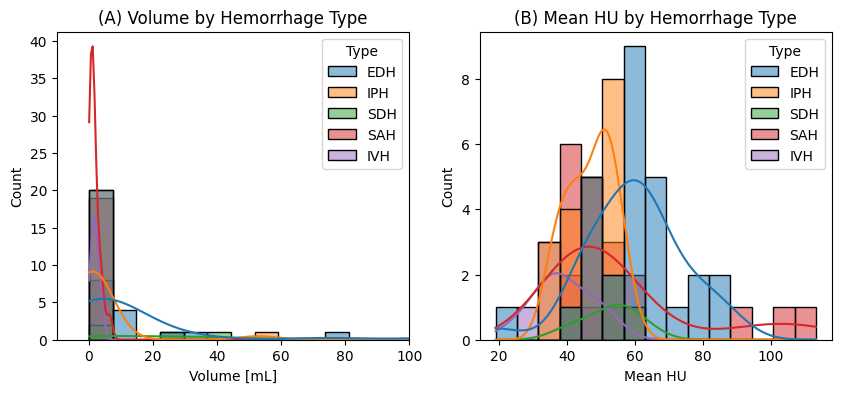

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig_df = df # make copy of main df
# Exclude SAH and IVH subtypes - out of scope for this work
# mask = fig_df['Type'] == 'SAH'
# fig_df = fig_df[~mask]
# mask = fig_df['Type'] == 'IVH'
# fig_df = fig_df[~mask]

print('Mean values of each metric by hemorrhage type:')
print(fig_df.groupby(['Type'])[['Mean_HU', 'Volume_[mL]', 'num_slices', 'z_dist']].mean())
print(' ')
print('Standard deviation of each metric by hemorrhage type:')
print(fig_df.groupby(['Type'])[['Mean_HU', 'Volume_[mL]', 'num_slices', 'z_dist']].std())
print(' ')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(ax=axes[0], data=fig_df, x='Volume_[mL]', hue='Type', bins=15, kde=True)
axes[0].set_title('(A) Volume by Hemorrhage Type')
axes[0].set_xlabel('Volume [mL]')
axes[0].set_xlim([-10, 100]) # there is a very small number of hemorrhages with volumes between 100-200 mL, excluding from visualization
sns.histplot(ax=axes[1], data=fig_df, x='Mean_HU', hue='Type', bins=15, kde=True, legend=True)
axes[1].set_title('(B) Mean HU by Hemorrhage Type')
axes[1].set_xlabel('Mean HU')

### Extract volume KDE distributions for use in InSilicoIVH source code

In [ ]:
# Plot each KDE and extract x- and y- axis data
fig, axes = plt.subplots(1, 5, figsize=(25,4))
fig.suptitle('Volume KDE for each hemorrhage type')
axes[0].set_title('IPH')
sns.kdeplot(ax=axes[0], data=df.loc[df['Type'] == 'IPH'], x="Volume_[mL]", fill=True, alpha=0.5, thresh=0.02)
x_IPH, y_IPH = sns.kdeplot(ax=axes[0], data=df.loc[df['Type'] == 'IPH'], x="Volume_[mL]", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[0].plot(x_IPH, y_IPH, '--r')

axes[1].set_title('IVH')
sns.kdeplot(ax=axes[1], data=df.loc[df['Type'] == 'IVH'], x="Volume_[mL]", fill=True, alpha=0.5)
x_IVH, y_IVH = sns.kdeplot(ax=axes[1], data=df.loc[df['Type'] == 'IVH'], x="Volume_[mL]", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[1].plot(x_IVH, y_IVH, '--r')

axes[2].set_title('SDH')
sns.kdeplot(ax=axes[2], data=df.loc[df['Type'] == 'SDH'], x="Volume_[mL]", fill=True, alpha=0.5)
x_SDH, y_SDH = sns.kdeplot(ax=axes[2], data=df.loc[df['Type'] == 'SDH'], x="Volume_[mL]", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[2].plot(x_SDH, y_SDH, '--r')

axes[3].set_title('SAH')
sns.kdeplot(ax=axes[3], data=df.loc[df['Type'] == 'SAH'], x="Volume_[mL]", fill=True, alpha=0.5)
x_SAH, y_SAH = sns.kdeplot(ax=axes[3], data=df.loc[df['Type'] == 'SAH'], x="Volume_[mL]", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[3].plot(x_SAH, y_SAH, '--r')

axes[4].set_title('EDH')
sns.kdeplot(ax=axes[4], data=df.loc[df['Type'] == 'EDH'], x="Volume_[mL]", fill=True, alpha=0.5)
x_EDH, y_EDH = sns.kdeplot(ax=axes[4], data=df.loc[df['Type'] == 'EDH'], x="Volume_[mL]", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[4].plot(x_EDH, y_EDH, '--r')

_ = plt.setp(axes, xlim=(-50,225), ylim=(0,0.06))

# Initialize dataframe
df_volume = pd.DataFrame(columns=['IPH_volume', 'IPH_weight', 
                                  'IVH_volume', 'IVH_weight',
                                  'SDH_volume', 'SDH_weight',
                                  'SAH_volume', 'SAH_weight',
                                  'EDH_volume', 'EDH_weight'])

min_volume = 0.01
max_volume = 100

df_volume['IPH_volume'] = np.pad(x_IPH[np.where((x_IPH > min_volume) & (x_IPH < max_volume))], (0, 200-len(x_IPH[np.where((x_IPH > min_volume) & (x_IPH < max_volume))])), 'constant')
df_volume['IPH_weight'] = np.pad(y_IPH[np.where((x_IPH > min_volume) & (x_IPH < max_volume))], (0, 200-len(x_IPH[np.where((x_IPH > min_volume) & (x_IPH < max_volume))])), 'constant')

df_volume['IVH_volume'] = np.pad(x_IVH[np.where((x_IVH > min_volume) & (x_IVH < max_volume))], (0, 200-len(x_IVH[np.where((x_IVH > min_volume) & (x_IVH < max_volume))])), 'constant')
df_volume['IVH_weight'] = np.pad(y_IVH[np.where((x_IVH > min_volume) & (x_IVH < max_volume))], (0, 200-len(x_IVH[np.where((x_IVH > min_volume) & (x_IVH < max_volume))])), 'constant')

df_volume['SDH_volume'] = np.pad(x_SDH[np.where((x_SDH > min_volume) & (x_SDH < max_volume))], (0, 200-len(x_SDH[np.where((x_SDH > min_volume) & (x_SDH < max_volume))])), 'constant')
df_volume['SDH_weight'] = np.pad(y_SDH[np.where((x_SDH > min_volume) & (x_SDH < max_volume))], (0, 200-len(x_SDH[np.where((x_SDH > min_volume) & (x_SDH < max_volume))])), 'constant')

df_volume['SAH_volume'] = np.pad(x_SAH[np.where((x_SAH > min_volume) & (x_SAH < max_volume))], (0, 200-len(x_SAH[np.where((x_SAH > min_volume) & (x_SAH < max_volume))])), 'constant')
df_volume['SAH_weight'] = np.pad(y_SAH[np.where((x_SAH > min_volume) & (x_SAH < max_volume))], (0, 200-len(x_SAH[np.where((x_SAH > min_volume) & (x_SAH < max_volume))])), 'constant')

df_volume['EDH_volume'] = np.pad(x_EDH[np.where((x_EDH > min_volume) & (x_EDH < max_volume))], (0, 200-len(x_EDH[np.where((x_EDH > min_volume) & (x_EDH < max_volume))])), 'constant')
df_volume['EDH_weight'] = np.pad(y_EDH[np.where((x_EDH > min_volume) & (x_EDH < max_volume))], (0, 200-len(x_EDH[np.where((x_EDH > min_volume) & (x_EDH < max_volume))])), 'constant')

if save_distributions:
    df_volume.to_csv('BHSD_volume_distributions.csv')

### Extract HU KDE distributions for use in InSilicoIVH source code

In [ ]:
# KDES
fig, axes = plt.subplots(1, 5, figsize=(25,4))
fig.suptitle('Mean HU KDE for each hemorrhage type')
axes[0].set_title('IPH')
sns.kdeplot(ax=axes[0], data=df.loc[df['Type'] == 'IPH'], x="Mean_HU", fill=True, alpha=0.5, thresh=0.02)
hu_IPH, den_IPH = sns.kdeplot(ax=axes[0], data=df.loc[df['Type'] == 'IPH'], x="Mean_HU", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[0].plot(hu_IPH, den_IPH, '--r')

axes[1].set_title('IVH')
sns.kdeplot(ax=axes[1], data=df.loc[df['Type'] == 'IVH'], x="Mean_HU", fill=True, alpha=0.5)
hu_IVH, den_IVH = sns.kdeplot(ax=axes[1], data=df.loc[df['Type'] == 'IVH'], x="Mean_HU", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[1].plot(hu_IVH, den_IVH, '--r')

axes[2].set_title('SDH')
sns.kdeplot(ax=axes[2], data=df.loc[df['Type'] == 'SDH'], x="Mean_HU", fill=True, alpha=0.5)
hu_SDH, den_SDH = sns.kdeplot(ax=axes[2], data=df.loc[df['Type'] == 'SDH'], x="Mean_HU", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[2].plot(hu_SDH, den_SDH, '--r')

axes[3].set_title('SAH')
sns.kdeplot(ax=axes[3], data=df.loc[df['Type'] == 'SAH'], x="Mean_HU", fill=True, alpha=0.5)
hu_SAH, den_SAH = sns.kdeplot(ax=axes[3], data=df.loc[df['Type'] == 'SAH'], x="Mean_HU", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[3].plot(hu_SAH, den_SAH, '--r')

axes[4].set_title('EDH')
sns.kdeplot(ax=axes[4], data=df.loc[df['Type'] == 'EDH'], x="Mean_HU", fill=True, alpha=0.5)
hu_EDH, den_EDH = sns.kdeplot(ax=axes[4], data=df.loc[df['Type'] == 'EDH'], x="Mean_HU", alpha=0.5, thresh=0.02).lines[0].get_data()
axes[4].plot(hu_EDH, den_EDH, '--r')

_ = plt.setp(axes, xlim=(0, 100), ylim=(0,0.08))

df_IPH_HU = pd.DataFrame(columns=['HU', 'weight'])
df_IVH_HU = pd.DataFrame(columns=['HU', 'weight'])
df_SDH_HU = pd.DataFrame(columns=['HU', 'weight'])
df_SAH_HU = pd.DataFrame(columns=['HU', 'weight'])
df_EDH_HU = pd.DataFrame(columns=['HU', 'weight'])

df_HU = pd.DataFrame(columns=['IPH_HU', 'IPH_weight', 
                                  'IVH_HU', 'IVH_weight',
                                  'SDH_HU', 'SDH_weight',
                                  'SAH_HU', 'SAH_weight',
                                  'EDH_HU', 'EDH_weight'])

df_HU['IPH_HU'] = hu_IPH
df_HU['IPH_weight'] = den_IPH

df_HU['IVH_HU'] = hu_IVH
df_HU['IVH_weight'] = den_IVH

df_HU['SDH_HU'] = hu_SDH
df_HU['SDH_weight'] = den_SDH

df_HU['SAH_HU'] = hu_SAH
df_HU['SAH_weight'] = den_SAH

df_HU['EDH_HU'] = hu_EDH
df_HU['EDH_weight'] = den_EDH

if save_distributions:
    df_HU.to_csv('BHSD_HU_distributions.csv')